Імпорт бібліотек

In [47]:
import sympy as sp
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Визначення функції

In [48]:
# Позначення цільової функції f
f = sp.Symbol('f', real=True)

# Аргументи цільової функції f
x, y, z = arguments = sp.symbols('x y z', real=True)

# Визначення цільової функції f
expression = 11*x**2 + 14*y**2 + z**2 + 0.01*x*y - 0.001*y*z - y
# min{expression}≈-0.0178571 at (x, y, z)≈(-0.0000162338, 0.0357143, 0.0000178571)

# Область визначення цільової функції f
domains = [sp.Contains(argument, sp.Reals - sp.singularities(expression, argument, sp.Reals), evaluate=False) \
           for argument in arguments]

print('Цільова функція')
display(sp.Eq(f, expression))
print('Область визначення')
for domain in domains:
    display(domain)

f = sp.lambdify(arguments, expression)

Цільова функція


Eq(f, 11*x**2 + 0.01*x*y + 14*y**2 - 0.001*y*z - y + z**2)

Область визначення


Contains(x, Reals)

Contains(y, Reals)

Contains(z, Reals)

Аналіз функції

In [49]:
# Матриця других похідних
hessian = sp.hessian(expression, arguments)

# Власні числа матриці других похідних
eigenvals = hessian.eigenvals()

print('Матриця Гессе')
display(hessian)
print('Власні числа')
for eigenval in eigenvals:
    display(eigenval)

if all(sp.evaluate(domain) for domain in domains) and \
   all(sp.singularities(eigenval, argument, sp.Reals).is_empty for eigenval in eigenvals for argument in arguments):
    is_convex = all(eigenval.is_nonnegative for eigenval in eigenvals)
    is_concave = all(eigenval.is_nonpositive for eigenval in eigenvals)
    if is_convex and is_concave:
        print('Функція лінійна (і слабо опукла, і слабо увігнута одночасно)')
    elif all(eigenval.is_positive for eigenval in eigenvals):
        if all(eigenval.is_number for eigenval in eigenvals):
            if min(eigenvals) / max(eigenvals) < 0.5:
                print('Функція ярно опукла')
            else:
                print('Функція неярно сильно опукла')
        else:
            print('Функція щонайменше строго опукла (сильно - за умови, що інфімуми кожного власного числа додатні)')
    elif is_convex:
        print('Функція лише слабо опукла')
    elif all(eigenval.is_negative for eigenval in eigenvals):
        if all(eigenval.is_number for eigenval in eigenvals):
            if max(eigenvals) / min(eigenvals) < 0.5:
                print('Функція ярно увігнута')
            else:
                print('Функція неярно сильно увігнута')
        else:
            print('Функція щонайменше строго увігнута (сильно - за умови, що супремуми кожного власного числа від\'ємні)')
    elif is_concave:
        print('Функція лише слабо увігнута')
    else:
        print('Функція хвиляста (ні навіть слабо опукла, ні навіть слабо увігнута)')
else:
    print('Власні числа визначені не для всіх дійсних значень аргументів')

Матриця Гессе


Matrix([
[  22,   0.01,      0],
[0.01,     28, -0.001],
[   0, -0.001,      2]])

Власні числа


21.9999833333798

28.0000167050818

1.99999996153845

Функція ярно опукла


Демонстрація функції

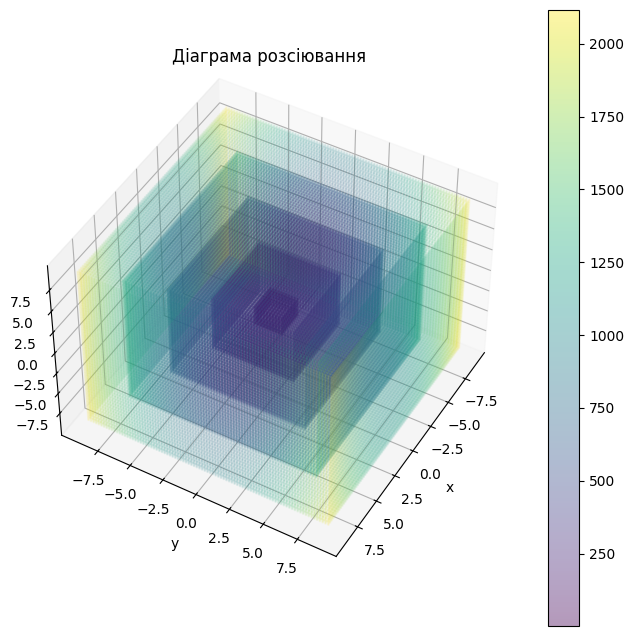

In [50]:
# Діаграма розсіювання
def draw(scale=0.1, df=pd.DataFrame()):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')
    layers = np.arange(10, 101, 20)
    alphas = np.linspace(0.4, 0.1, len(layers))
    grids = []
    for layer, alpha in zip(layers, alphas):
        b = layer * scale
        a = -b
        x_values = np.linspace(a, b, layer)
        y_values = np.linspace(a, b, layer)
        z_values = np.linspace(a, b, layer)
        X, Y, Z = np.meshgrid(x_values, y_values, z_values)
        F = f(X, Y, Z)
        arr = (
            np.isclose(X, a), np.isclose(X, b), 
            np.isclose(Y, a), np.isclose(Y, b), 
            np.isclose(Z, a), np.isclose(Z, b)
        )
        mask = np.logical_or.reduce(arr)
        grids.append((X[mask], Y[mask], Z[mask], F[mask]))
    vmin = np.min([np.min(F) for _, _, _, F in grids])
    vmax = np.max([np.max(F) for _, _, _, F in grids])
    for i, ((X, Y, Z, F), alpha) in enumerate(zip(grids, alphas)):
        sc = ax.scatter(X, Y, Z, c=F, cmap='viridis', s=1, alpha=alpha, vmin=vmin, vmax=vmax)
        if i == 0:
            fig.colorbar(sc)
    ax.view_init(elev=45.0, azim=30.0)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    if df.empty:
        ax.set_title('Діаграма розсіювання')
    else:
        ax.plot(df['x'], df['y'], df['z'], c='red', alpha=1.0)
        ax.set_title('Траєкторія мінімізації')
    plt.show()

draw()

Чисельні центральні скінченні різницеві формули часткових похідних

In [51]:
# Визначення адаптивного кроку
h_x = lambda x: 0.1 * abs(x) if x != 0.0 else 1e-6
h_y = lambda y: 0.1 * abs(y) if y != 0.0 else 1e-6
h_z = lambda z: 0.1 * abs(z) if z != 0.0 else 1e-6

# Похідні першого порядку
f_x = lambda x, y, z: (f(x + h_x(x), y, z) - f(x - h_x(x), y, z)) / (2 * h_x(x))
f_y = lambda x, y, z: (f(x, y + h_y(y), z) - f(x, y - h_y(y), z)) / (2 * h_y(y))
f_z = lambda x, y, z: (f(x, y, z + h_z(z)) - f(x, y, z - h_z(z))) / (2 * h_z(z))

# Похідні другого порядку
f_xx = lambda x, y, z: (f(x + h_x(x), y, z) - 2 * f(x, y, z) + f(x - h_x(x), y, z)) / (h_x(x)**2)
f_xy = lambda x, y, z: (f_x(x, y + h_y(y), z) - f_x(x, y - h_y(y), z)) / (2 * h_y(y))
f_xz = lambda x, y, z: (f_x(x, y, z + h_z(z)) - f_x(x, y, z - h_z(z))) / (2 * h_z(z))

f_yx = lambda x, y, z: (f_y(x + h_x(x), y, z) - f_y(x - h_x(x), y, z)) / (2 * h_x(x))
f_yy = lambda x, y, z: (f(x, y + h_y(y), z) - 2 * f(x, y, z) + f(x, y - h_y(y), z)) / (h_y(y)**2)
f_yz = lambda x, y, z: (f_y(x, y, z + h_z(z)) - f_y(x, y, z - h_z(z))) / (2 * h_z(z))

f_zx = lambda x, y, z: (f_z(x + h_x(x), y, z) - f_z(x - h_x(x), y, z)) / (2 * h_x(x))
f_zy = lambda x, y, z: (f_z(x, y + h_y(y), z) - f_z(x, y - h_y(y), z)) / (2 * h_y(y))
f_zz = lambda x, y, z: (f(x, y, z + h_z(z)) - 2 * f(x, y, z) + f(x, y, z - h_z(z))) / (h_z(z)**2)

# Функція обчислення градієнта функції f у точці
gradient = lambda x, y, z: np.array((f_x(x, y, z), f_y(x, y, z), f_z(x, y, z)))

# Функція обчислення матриці Гессе функції f у точці
hessian = lambda x, y, z: np.array((
    (f_xx(x, y, z), f_xy(x, y, z), f_xz(x, y, z)),
    (f_yx(x, y, z), f_yy(x, y, z), f_yz(x, y, z)),
    (f_zx(x, y, z), f_zy(x, y, z), f_zz(x, y, z))
))

Програма мінімізації методом спряжених градієнтів

In [52]:
# Функція мінімізації
def minimize(xk, yk, zk, filename, eps1=1e-6, eps2=1e-6, eps3=1e-6, kmax=1000):

    # Ініціалізація значень
    alpha = np.nan

    epk1 = np.inf
    epk2 = np.inf
    epk3 = np.inf

    k = 0

    valuek = f(xk, yk, zk)
    grad = gradient(xk, yk, zk)
    hk = -grad

    # Запис у файл
    with open(filename, 'w') as file:
        file.write(f'x\ty\tz\tf(x, y, z)\talpha\tepk1\tepk2\tepk3\n'
                   f'{xk}\t{yk}\t{zk}\t{valuek}\t{alpha}\t{epk1}\t{epk2}\t{epk3}\n')

    # Цикл, що перевіряє виконання хоча б одного критерія зупинки
    while epk1 > eps1 and epk2 > eps2 and epk3 > eps3 and k < kmax:
        
        # Обчислення оптимальної довжини кроку методом найшвидшого спуску
        numerator = grad @ hk
        denominator = hessian(xk, yk, zk) @ hk @ hk
        alpha = -numerator / denominator if denominator else 0.0

        # Процедура градієнтного спуску
        x, y, z = (xk, yk, zk) + alpha * hk
        value = f(x, y, z)
        grad = gradient(x, y, z)

        # Обчислення похибок
        epk1 = np.linalg.norm((x - xk, y - yk, z - zk))
        epk2 = np.abs(value - valuek)
        epk3 = np.linalg.norm(grad)

        # Оновлення поточних значень
        k, xk, yk, zk, valuek = k + 1, x, y, z, value

        # Запис у файл
        with open(filename, 'a') as file:
            file.write(f"{xk}\t{yk}\t{zk}\t{valuek}\t{alpha}\t{epk1}\t{epk2}\t{epk3}\n")

        # Наступний напрям кроку
        Ahk = hessian(xk, yk, zk) @ hk
        numerator = Ahk @ grad
        denominator = Ahk @ hk
        beta = numerator / denominator if denominator else 0.0
        hk = -grad + beta * hk

    return pd.read_csv(filename, delimiter='\t')

Випробування

,x,y,z,"f(x, y, z)",alpha,epk1,epk2,epk3
0,10540.000000,20005.000000,-40406.000000,8.460350e+09,NaN,inf,inf,inf
1,1844.603578,-987.319234,-37377.448743,1.448095e+09,0.037467,2.292290e+04,7.012255e+09,8.941700e+04
2,-3832.700497,960.746651,-27840.534242,9.495923e+08,0.124697,1.126852e+04,4.985026e+08,1.045546e+05
3,-0.000016,0.035714,0.000018,-1.785715e-02,0.173732,2.811953e+04,9.495923e+08,5.082599e-08


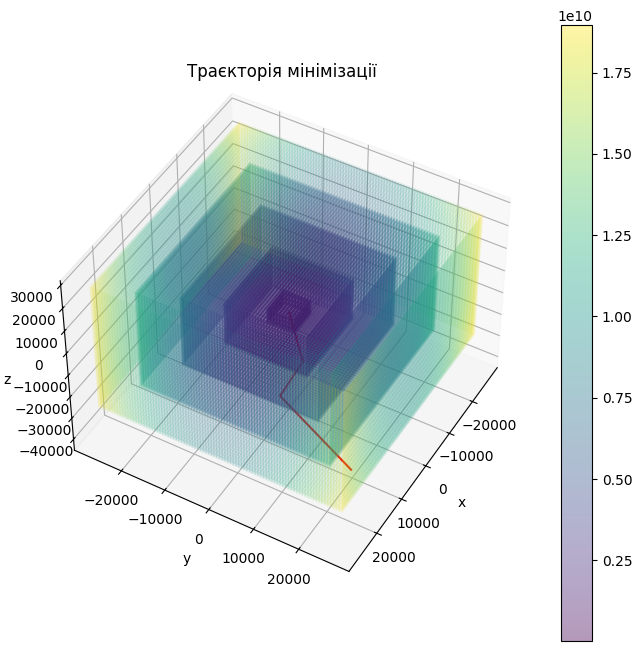

In [53]:
df1 = minimize(10540.0, 20005.0, -40406.0, 'df1.tsv', 0.0, 0.0)
display(df1)
draw(300.0, df1)

,x,y,z,"f(x, y, z)",alpha,epk1,epk2,epk3
0,0.000000,0.000000,0.000000,0.000000,NaN,inf,inf,inf
1,0.000000,0.035714,0.000000,-0.017857,0.035714,0.035714,1.785714e-02,3.589241e-04
2,-0.000016,0.035714,0.000002,-0.017857,0.045867,0.000016,2.954469e-09,3.259983e-05
3,-0.000016,0.035714,0.000018,-0.017857,0.495531,0.000016,2.632959e-10,2.075226e-09


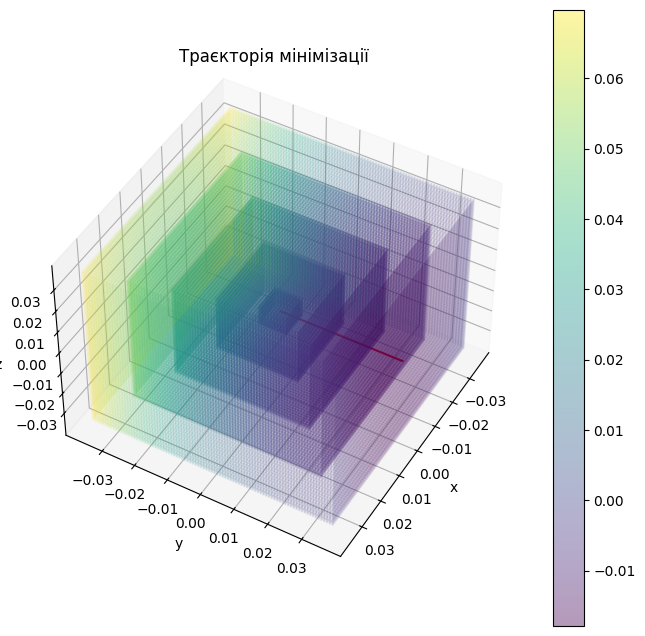

In [54]:
df2 = minimize(0.0, 0.0, 0.0, 'df2.tsv', 0.0, 0.0)
display(df2)
draw(0.0004, df2)

,x,y,z,"f(x, y, z)",alpha,epk1,epk2,epk3
0,-15.000000,24.000000,-44.000000,12448.456000,NaN,inf,inf,inf
1,-2.549321,-1.330804,-40.676496,1752.171905,0.037757,28.420322,1.069628e+04,1.059622e+02
2,3.431943,1.052064,-32.741096,1216.054156,0.095497,10.218814,5.361177e+02,1.039422e+02
3,-0.000016,0.035714,0.000018,-0.017857,0.225116,32.936178,1.216072e+03,2.254719e-11


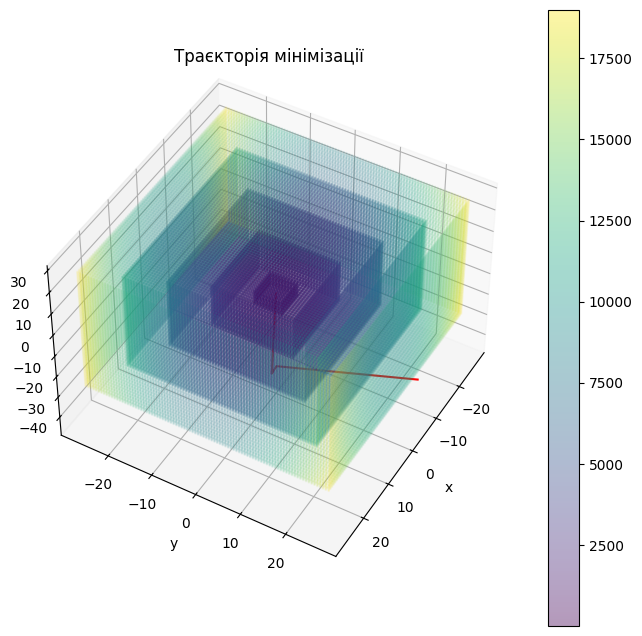

In [55]:
df3 = minimize(-15.0, 24.0, -44.0, 'df3.tsv')
display(df3)
draw(0.3, df3)